In [5]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [7]:
df.dropna(inplace=True)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df = df[~(df['clean_comment'].str.strip() == '')]

In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Suraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Suraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [13]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [14]:
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [15]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [17]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [18]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
X.shape

(36793, 10000)

In [20]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
37244    0
37245    1
37246    0
37247    1
37248    0
Name: category, Length: 36793, dtype: int64

In [21]:
y.shape

(36793,)

Training Random Forest Model...
Vectorizer: CountVectorizer | max_features=10000
n_estimators=200, max_depth=15

Final Accuracy: 0.6479141187661367

Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



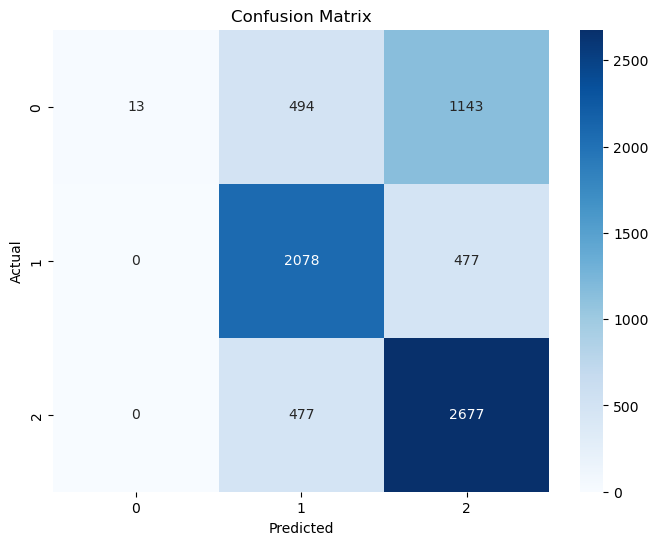


Model saved as random_forest_model.pkl
Dataset saved as dataset.csv
Confusion matrix saved as confusion_matrix.png


In [22]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split

# Parameters
n_estimators = 200
max_depth = 15
vectorizer_type = "CountVectorizer"
vectorizer_max_features = vectorizer.max_features

print("Training Random Forest Model...")
print(f"Vectorizer: {vectorizer_type} | max_features={vectorizer_max_features}")
print(f"n_estimators={n_estimators}, max_depth={max_depth}")

# Initialize and train the model
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Accuracy: {accuracy}")

# Classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

# Confusion matrix plot
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Save confusion matrix
plt.savefig("confusion_matrix.png")
plt.show()

# Save the trained model
import joblib
joblib.dump(model, "random_forest_model.pkl")

# Save the dataset
df.to_csv("dataset.csv", index=False)

print("\nModel saved as random_forest_model.pkl")
print("Dataset saved as dataset.csv")
print("Confusion matrix saved as confusion_matrix.png")


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02      1650
           0       0.68      0.81      0.74      2555
           1       0.62      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359



In [24]:
df.to_csv('reddit_preprocessing.csv', index=False)

In [25]:
pd.read_csv('reddit_preprocessing.csv').head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


### Improving baseline model

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os


In [27]:
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
print(df.shape)

(36662, 2)


In [28]:
def run_experiment(vectorizer_type, ngram_range, vectorizer_max_features, vectorizer_name):

    print(f"\n========== Running: {vectorizer_name} | ngram={ngram_range} ==========\n")

    # Step 1: Vectorizer
    if vectorizer_type == "BoW":
        vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)
    else:
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vectorizer_max_features)

    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_comment'],
        df['category'],
        test_size=0.2,
        random_state=42,
        stratify=df['category']
    )

    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Step 2: Random Forest Model
    n_estimators = 200
    max_depth = 15

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Step 3: Predictions
    y_pred = model.predict(X_test)

    # Step 4: Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    report = classification_report(y_test, y_pred)
    print(report)

    # Step 5: Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {vectorizer_name}, {ngram_range}")
    plt.show()


========== Running: BoW | ngram=(1, 1) ==========

Accuracy: 0.6480294558843583
              precision    recall  f1-score   support

          -1       0.97      0.02      0.04      1650
           0       0.66      0.84      0.74      2529
           1       0.64      0.83      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.76      0.56      0.50      7333
weighted avg       0.72      0.65      0.57      7333



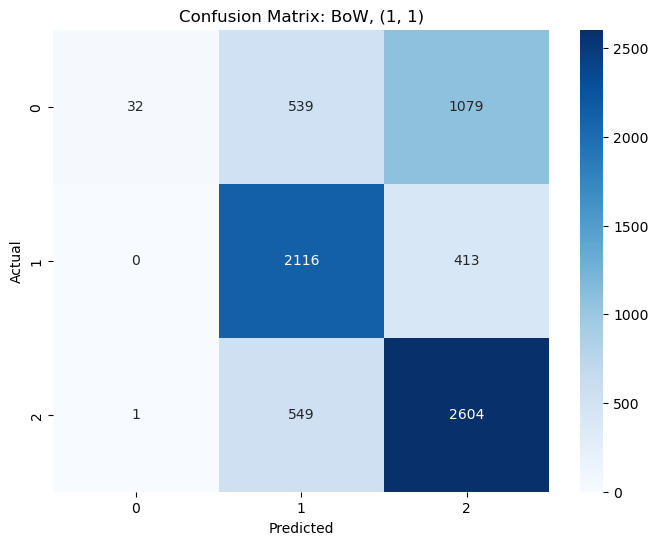


========== Running: TF-IDF | ngram=(1, 1) ==========

Accuracy: 0.6491204145642984
              precision    recall  f1-score   support

          -1       0.97      0.02      0.04      1650
           0       0.66      0.84      0.74      2529
           1       0.64      0.83      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.76      0.56      0.50      7333
weighted avg       0.72      0.65      0.57      7333



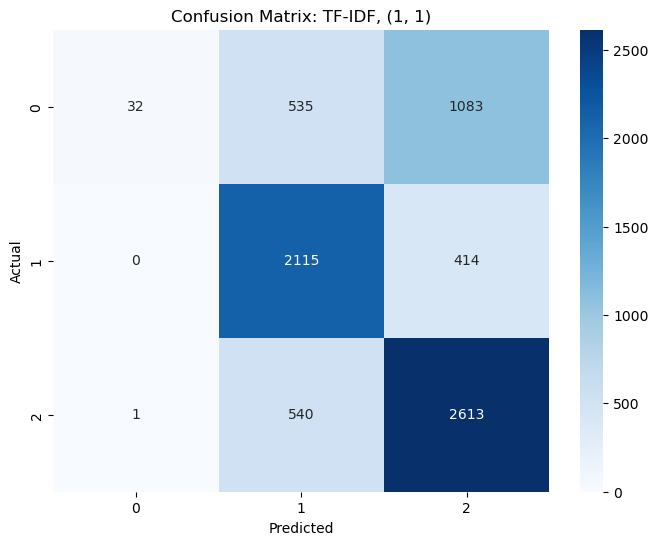


========== Running: BoW | ngram=(1, 2) ==========

Accuracy: 0.6568934951588709
              precision    recall  f1-score   support

          -1       0.90      0.04      0.09      1650
           0       0.67      0.84      0.75      2529
           1       0.64      0.83      0.72      3154

    accuracy                           0.66      7333
   macro avg       0.74      0.57      0.52      7333
weighted avg       0.71      0.66      0.59      7333



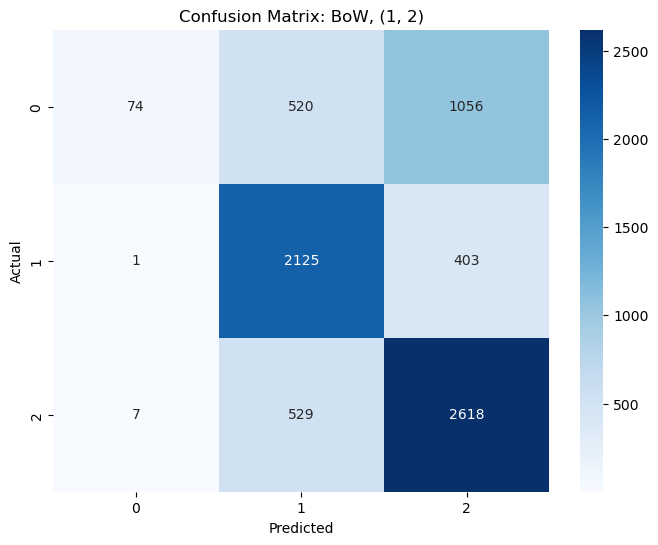


========== Running: TF-IDF | ngram=(1, 2) ==========

Accuracy: 0.6567571253238783
              precision    recall  f1-score   support

          -1       0.94      0.04      0.07      1650
           0       0.67      0.84      0.75      2529
           1       0.64      0.83      0.73      3154

    accuracy                           0.66      7333
   macro avg       0.75      0.57      0.51      7333
weighted avg       0.72      0.66      0.59      7333



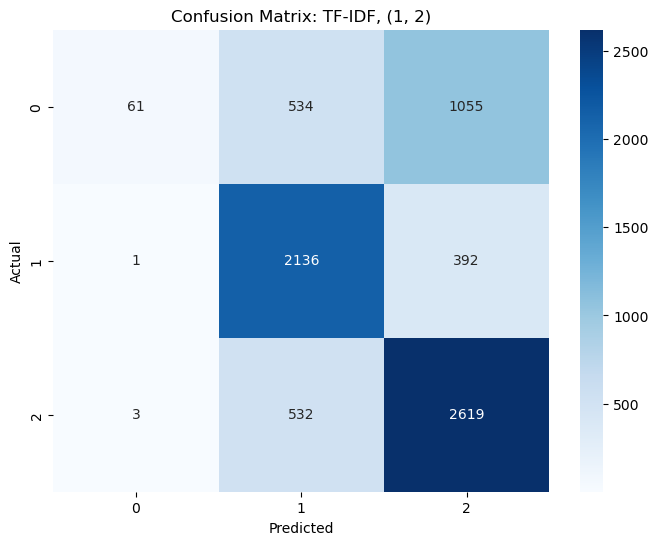


========== Running: BoW | ngram=(1, 3) ==========

Accuracy: 0.6517114414291558
              precision    recall  f1-score   support

          -1       0.94      0.03      0.06      1650
           0       0.66      0.84      0.74      2529
           1       0.64      0.83      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.75      0.57      0.51      7333
weighted avg       0.72      0.65      0.58      7333



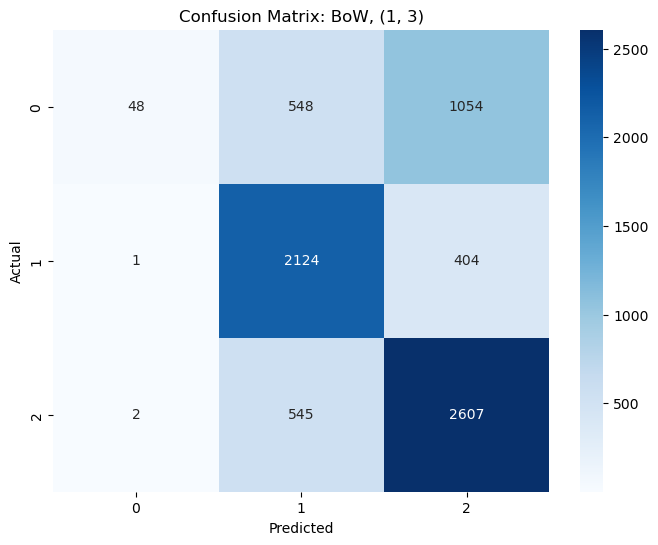


========== Running: TF-IDF | ngram=(1, 3) ==========

Accuracy: 0.6532115096140734
              precision    recall  f1-score   support

          -1       0.98      0.03      0.05      1650
           0       0.66      0.84      0.74      2529
           1       0.64      0.83      0.72      3154

    accuracy                           0.65      7333
   macro avg       0.76      0.57      0.51      7333
weighted avg       0.72      0.65      0.58      7333



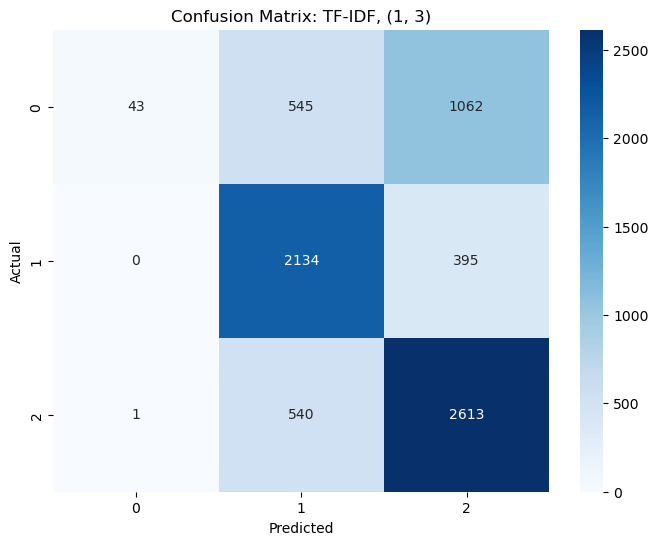

In [29]:
ngram_ranges = [(1, 1), (1, 2), (1, 3)]   # unigrams, bigrams, trigrams
max_features = 5000

for ngram_range in ngram_ranges:
    run_experiment("BoW", ngram_range, max_features, vectorizer_name="BoW")
    run_experiment("TF-IDF", ngram_range, max_features, vectorizer_name="TF-IDF")

### tfidf-(1,3)-max_features

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [31]:
# =============== Run Experiment Function ===============
def run_experiment_tfidf_max_features(max_features):
    ngram_range = (1, 3)  # Trigram TF-IDF

    print(f"\n========== Running Experiment: TF-IDF Trigram | max_features={max_features} ==========\n")

    # Vectorizer
    vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        max_features=max_features
    )

    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_comment'],
        df['category'],
        test_size=0.2,
        random_state=42,
        stratify=df['category']
    )

    # Transform
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # RF Model
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Prediction
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}\n")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix | TF-IDF Trigrams | max_features={max_features}")

    # Save unique image
    img_name = f"conf_matrix_tfidf_trigram_{max_features}.png"
    plt.savefig(img_name)
    plt.close()

    print(f"Saved Confusion Matrix → {img_name}\n")

In [32]:
max_features_values = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for max_features in max_features_values:
    run_experiment_tfidf_max_features(max_features)


========== Running Experiment: TF-IDF Trigram | max_features=1000 ==========

Accuracy: 0.6618028092186008

Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.13      0.23      1650
           0       0.62      0.89      0.73      2529
           1       0.69      0.75      0.72      3154

    accuracy                           0.66      7333
   macro avg       0.73      0.59      0.56      7333
weighted avg       0.71      0.66      0.61      7333

Saved Confusion Matrix → conf_matrix_tfidf_trigram_1000.png


========== Running Experiment: TF-IDF Trigram | max_features=2000 ==========

Accuracy: 0.6589390426837584

Classification Report:
              precision    recall  f1-score   support

          -1       0.90      0.08      0.14      1650
           0       0.64      0.88      0.74      2529
           1       0.66      0.79      0.72      3154

    accuracy                           0.66      7333
   macro avg       0.7